In [1]:
import scipy.io as scio
import os
import numpy as np
import sklearn.metrics as metrics
from sklearn import svm
from catboost import CatBoostClassifier
import xgboost as xgb
from keras import layers
from keras import models
import pandas as pd
from sklearn.metrics import f1_score,recall_score,precision_score,auc,accuracy_score,confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from scipy import interp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns


D:\Anaconda\envs\tensorflow\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#此代码读取部分数据的代码

path='./1HP/'
#寻找文件夹下所有的数据文件
path_list=os.listdir(path)
data_x=[]
data_y=[]
for i in path_list:
    path1=path+i
    dd=scio.loadmat(path1)
    for j in dd.keys():
        #只使用DE的数据
        if 'DE' in j:
            ddd=dd[j]
            #截前12W个数据
            data_x.append(ddd[:120000].ravel())
            data_y.append(i)
            # print(data_x)
            
# data_x=np.array(data_x)

In [3]:
#从完整的一条数据中切分成多个样本数据
def yuchuli(a,label):
    """
    前200个样本用于训练
    后100个样本用于测试
    """
    a  = a.reshape(300,400)
    np.random.shuffle(a)
    train = a[:200,:]
    test = a[200:,:]
    label_train = [label for i in range(0, 200)]
    label_test =[label for i in range(0,100)]
    return train,test,label_train ,label_test



#生成结果
def get_result(Y_test, Y_pred):
    test_acc_rate=accuracy_score(Y_test, Y_pred)
    test_pre_rate=precision_score(Y_test, Y_pred, average='weighted')
    test_recall_rate=recall_score(Y_test, Y_pred, average='weighted')
    test_f1=f1_score(Y_test, Y_pred, average='weighted')
    return test_acc_rate,test_pre_rate,test_recall_rate,test_f1

#绘制混淆矩阵
def plt_heatmap(y_true,y_pred,title=None,path=None):
    cm=confusion_matrix(y_true,y_pred)
    cm=cm/cm.sum(axis=1)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True,cmap='rainbow')
    plt.xlabel('True label', fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel('Predict label', fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
    if path != None:
        plt.savefig(path,dpi=700)
    plt.show()

#绘制P-R曲线
def micro_PR(y_test,y_score):
    # 对每一个类别计算性能指标
    precision = dict()
    recall = dict()
    average_precision = dict()
    # .shape会返回一个元组，存储行和列，取第二个数，也就是列
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        precision[i], recall[i], _ =  precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    precision["micro"],  recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
    return precision, recall, average_precision

def plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None):
    plt.figure(figsize=(6,6))
    for i in precision.keys():
        label = str(i)+"，AP = {0:0.4f}".format(average_precision[i])
        plt.step(recall[i], precision[i], where='post', lw=2,label=label)
    plt.legend()
    plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
        
    if path!= None:
        plt.savefig(path,dpi=700)
    plt.show()

#绘制ROC曲线
def get_ROC_AUC(Y_true_1,Y_pred_1,labels,title=None,path=None):

    #计算数据的4个指标
    plt.figure(figsize=(6,6))
    n_classes=len(labels)
    fpr,tpr, roc_auc= dict(),dict(),dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_true_1[:, i], Y_pred_1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    lw = 2

    plt.plot(fpr["macro"], tpr["macro"],label='Average ROC (AUC = {0:0.4f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],lw=lw,label=str(labels[i])+'(AUC = {0:0.4f})'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1],'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (%)', fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel('Sensitivity (%)', fontdict={'weight': 'normal', 'size': 15})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc="lower right")
    
    if title != None:
        plt.title(title)
        
    if path!= None:
        plt.savefig(path,dpi=700)
    plt.show()  
    
    return roc_auc["macro"]
    
#将y转变为onehot向量
def to_one_hot(labels,label_dict):
    dimension=len(label_dict.keys())
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label_dict[label]] = 1
    return results

#画损失函数
def plot_loss(history,columns,title=None,path=None):
    plt.figure(figsize=(6,6))
    history[columns].plot()
    if title != None:
        plt.title(title)
    if path != None:
        plt.savefig(path,dpi=700)
    plt.show()
    
#将所有模型的PR曲线绘制在一张图上
def plt_show(precision, recall, average_precision, model_name):
    # 绘制P-R曲线, 使用阶梯图
    label = model_name+"，AP = {0:0.2f}".format(average_precision["micro"])
    plt.step(recall["micro"], precision["micro"], where='post', lw=2, label=label)
    
#将所有模型的PR绘制在一张图上
def plot_all_model_PR_2_a_pic(get_pre_rec_ave,title=None,path=None):
    plt.figure(figsize=(6,6))
    for iii in get_pre_rec_ave:
        plt_show(iii[0], iii[1], iii[2], iii[3])
    plt.plot([0,1.05], [0,1.05], color="navy", ls="--")
    plt.legend(fontsize=8)
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
    if path!=None:
        plt.savefig(path,dpi=700)
    plt.show()
    
#创建CNN模型
def creat_model(input_shape,output,train_or_test='train'):
    """
    train_or_test：用于识别该模型的任务是什么，如果是train则为训练，需要所有的结构；如果为test，则只需要最后隐藏层的输出
    """
    model = models.Sequential()
    model.add(layers.Conv2D(60,(5,5),padding='same',activation='relu',input_shape=input_shape,name='conv1'))
    model.add(layers.MaxPooling2D((3,3),strides=2,name='max'))
    model.add(layers.Conv2D(128,(5,5),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((3,3),strides=2))
    model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((3,3),strides=2))
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(64,activation='relu',name='dense1'))
    if train_or_test=='train':
        model.add((layers.Dense(output,activation='softmax')))
        model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])    
    return model

def get_result_picture(all_result,title=None,path=None):
    x = np.arange(all_result.shape[1])# 生成横坐标范围
    columns=all_result.columns# 生成横坐标
    model_name_list=list(all_result.index)
    plt.figure(figsize=(10,8))
    for i in range(len(model_name_list)):
        plt.bar(x+0.15*i, all_result.iloc[i], width=0.15, label=model_name_list[i])
    plt.xticks(x+0.3*(i//2),columns)# 横坐标绑定
    plt.ylim(np.min(np.min(all_result))*0.99,1)
    plt.legend(loc="best")
    plt.xlabel('Evaluation',fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel('Value',fontdict={'weight': 'normal', 'size': 15})
    plt.ylim(collect_every_model_result.values.min()*0.99,collect_every_model_result.values.max()*1.01)
    if title != None:
        plt.title(title)
    if path!=None:
        plt.savefig(path,dpi=700)
    plt.show()

In [4]:
#将多条数据的所有样本合并起来
x_train,x_test,y_train,y_test=[],[],[],[]
for i in range(len(data_x)):
    train,test,label_train ,label_test=yuchuli(data_x[i],data_y[i])
    x_train+=list(train)
    x_test+=list(test)
    y_train+=label_train
    y_test+=label_test
    
#转换数据格式
x_train=np.array(x_train)
x_test=np.array(x_test)

#将x转变为二维矩阵，方便CNN训练
x_train = x_train.reshape(-1,20,20,1)
x_test = x_test.reshape(-1,20,20,1)

#打乱训练集的顺序，防止模型学会欺骗
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)


#转换y的数据格式
y_train=np.array(y_train)
y_test=np.array(y_test)

#生成label的字典，用于将y转换为onehot格式
label_dict={}
label_dict_anti={}
for i,j in enumerate(list(set(list(y_train)+list(y_test)))):
    label_dict[j]=i
    label_dict_anti[i]=j
    
#将label转化为onehot向量
one_hot_train_labels = to_one_hot(y_train,label_dict)
one_hot_test_labels = to_one_hot(y_test,label_dict)

#将onehot向量转化为标签值
y_test_transform=np.argmax(one_hot_test_labels,axis=1)
y_train_transform=np.argmax(one_hot_train_labels,axis=1)

#获取数据的规模
input_shape=x_train.shape[1:]
output=one_hot_train_labels.shape[1]

In [5]:
#创建回收器，保存必要的结果
collect_every_model_result=[]#搜集所有模型的精确率等参数
collect_every_model_PR=[]#搜集模型的auc等参数，方便将所有模型的PR放在一张图上

Epoch 1/50
36/36 [==============================] - 8s 186ms/step - loss: 2.0429 - accuracy: 0.1828 - val_loss: 1.6667 - val_accuracy: 0.3100
Epoch 2/50
36/36 [==============================] - 8s 232ms/step - loss: 1.4410 - accuracy: 0.3933 - val_loss: 0.9483 - val_accuracy: 0.5600
Epoch 3/50
36/36 [==============================] - 7s 203ms/step - loss: 0.9061 - accuracy: 0.6294 - val_loss: 0.6207 - val_accuracy: 0.8050
Epoch 4/50
36/36 [==============================] - 7s 196ms/step - loss: 0.5957 - accuracy: 0.7656 - val_loss: 0.4182 - val_accuracy: 0.8800
Epoch 5/50
36/36 [==============================] - 7s 199ms/step - loss: 0.3661 - accuracy: 0.8628 - val_loss: 0.2399 - val_accuracy: 0.9350
Epoch 6/50
36/36 [==============================] - 8s 228ms/step - loss: 0.2204 - accuracy: 0.9267 - val_loss: 0.1743 - val_accuracy: 0.9700
Epoch 7/50
36/36 [==============================] - 8s 212ms/step - loss: 0.1504 - accuracy: 0.9461 - val_loss: 0.1428 - val_accuracy: 0.9600
Epoch 

<Figure size 432x432 with 0 Axes>

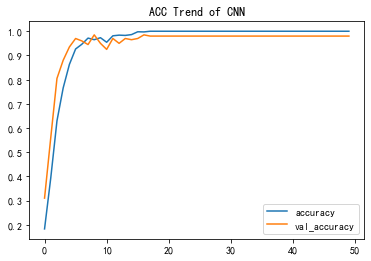

<Figure size 432x432 with 0 Axes>

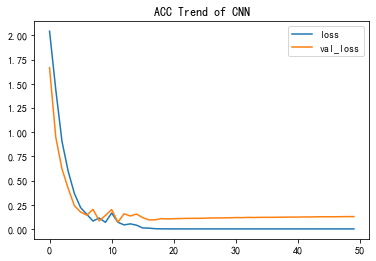

CNN's result 
 accuracy= 0.979 	 precision= 0.9790586993728053 	 recall= 0.979 	 F1= 0.9789520871369721


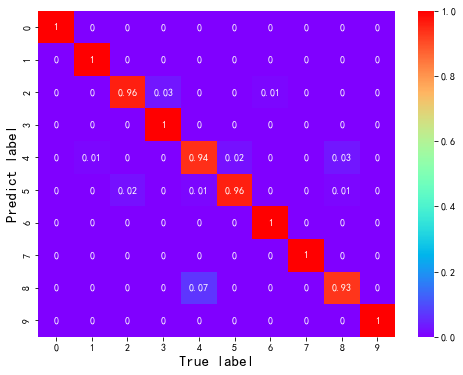

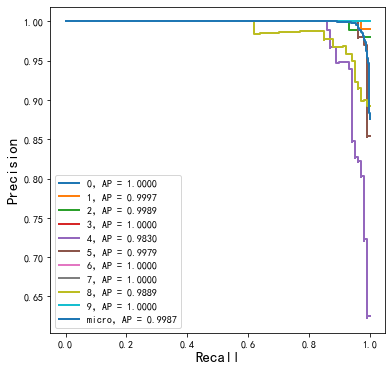

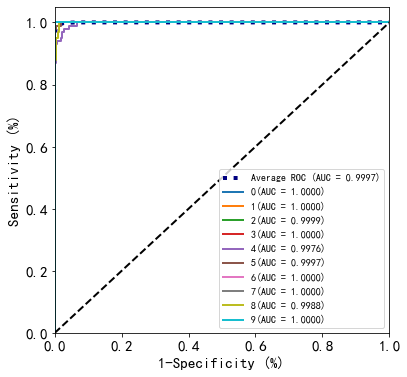

In [6]:
 #创建模型，训练
model=creat_model(input_shape,output)
history = model.fit(x_train,one_hot_train_labels,epochs=50,validation_split=0.1,batch_size=50)

#将训练结果保存在Dataframe格式中
history=pd.DataFrame(history.history)

#保存模型参数，用于提取输出特征
model.save_weights('./CNN_weight.pkl')

#数据可视化
#可视化1，查看损失曲线，观察模型过拟合的临界训练次数    
plot_loss(history,['accuracy','val_accuracy'],title='ACC Trend of CNN')
plot_loss(history,['loss','val_loss'],title='ACC Trend of CNN')


#用CNN模型预测测试集的结果
CNN_pred_test=model.predict(x_test)
CNN_pred_test_1=np.argmax(CNN_pred_test,axis=1)

#计算CNN的结果
acc,pre,rec,f1=get_result(y_test_transform,CNN_pred_test_1)
print('CNN\'s result \n accuracy= {} \t precision= {} \t recall= {} \t F1= {}'.format(acc,pre,rec,f1))

#CNN分类结果的混淆矩阵   
plt_heatmap(y_test_transform,CNN_pred_test_1,title=None,path=None)

#CNN的P-R曲线    
precision, recall, average_precision = micro_PR(one_hot_test_labels,CNN_pred_test)
plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None)

#画ROC曲线
roc_auc=get_ROC_AUC(one_hot_test_labels,CNN_pred_test,list(label_dict.values()),title=None,path=None)

#回收结果
collect_every_model_result.append([acc,pre,rec,f1,roc_auc,'CNN'])
collect_every_model_PR.append([precision, recall, average_precision,'CNN'])

In [7]:
#创建新的模型，结构与原来的结构一致
model2 = creat_model(input_shape,output,train_or_test='test')

#加载原来保存的权重参数
model2.load_weights('./CNN_weight.pkl')

#用训练集/测试集获取CNN提取的特征
x_temp1=model2.predict(x_train)
x_temp2=model2.predict(x_test)

0:	total: 110ms	remaining: 55s
1:	total: 182ms	remaining: 45.4s
2:	total: 303ms	remaining: 50.2s
3:	total: 359ms	remaining: 44.5s
4:	total: 444ms	remaining: 43.9s
5:	total: 503ms	remaining: 41.4s
6:	total: 574ms	remaining: 40.4s
7:	total: 710ms	remaining: 43.7s
8:	total: 775ms	remaining: 42.3s
9:	total: 840ms	remaining: 41.1s
10:	total: 908ms	remaining: 40.4s
11:	total: 1s	remaining: 40.7s
12:	total: 1.06s	remaining: 39.7s
13:	total: 1.22s	remaining: 42.3s
14:	total: 1.27s	remaining: 41.2s
15:	total: 1.32s	remaining: 39.9s
16:	total: 1.4s	remaining: 39.6s
17:	total: 1.5s	remaining: 40.2s
18:	total: 1.55s	remaining: 39.4s
19:	total: 1.6s	remaining: 38.5s
20:	total: 1.66s	remaining: 37.8s
21:	total: 1.71s	remaining: 37.2s
22:	total: 1.78s	remaining: 36.9s
23:	total: 1.83s	remaining: 36.4s
24:	total: 1.88s	remaining: 35.8s
25:	total: 1.94s	remaining: 35.4s
26:	total: 2s	remaining: 35.1s
27:	total: 2.07s	remaining: 34.8s
28:	total: 2.12s	remaining: 34.4s
29:	total: 2.18s	remaining: 34.2s
3

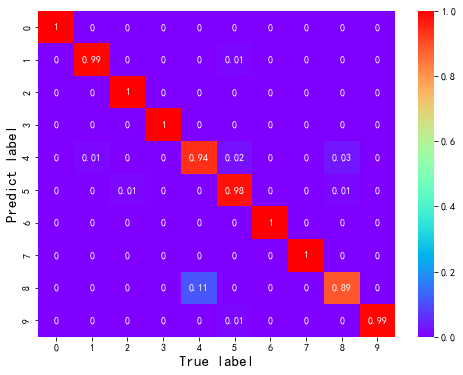

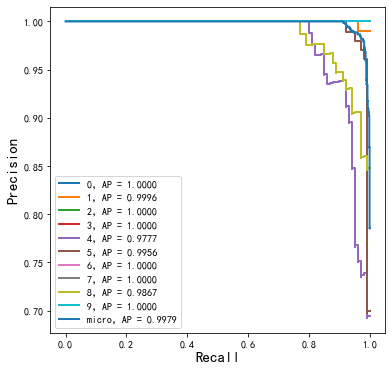

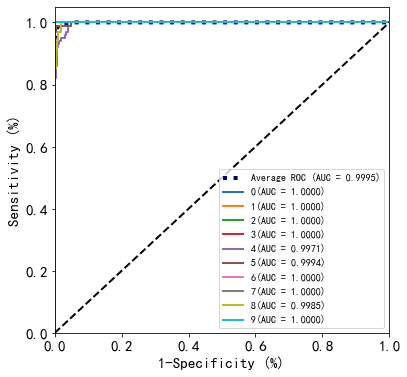

In [8]:
#创建CNN+catboost模型，此处核函数为线性核函数
cv_params  = {'depth': [8,9,10,11,12,13,14]}
other_params = {'iterations': 800,'learning_rate': 0.09}
cbc = CatBoostClassifier(eval_metric="AUC", depth=4, iterations=500, l2_leaf_reg=1,learning_rate=0.1)
                
cbc.fit(x_temp1, y_train_transform)
cbc_pred_test=cbc.predict_proba(x_temp2)
cbc_pred_test_1=np.argmax(cbc_pred_test,axis=1)

#计算catboost的结果
acc,pre,rec,f1=get_result(y_test_transform,cbc_pred_test_1)
print('CNN+catboost\'s result \n accuracy= {} \t precision= {} \t recall= {} \t F1= {}'.format(round(acc,5),round(pre,5),round(rec,5),round(f1,5)))

#catboost分类结果的混淆矩阵   
plt_heatmap(y_test_transform,cbc_pred_test_1,title=None,path=None)

#catboost的P-R曲线    
precision, recall, average_precision = micro_PR(one_hot_test_labels,cbc_pred_test)
plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None)

#画catboost的ROC曲线
roc_auc=get_ROC_AUC(one_hot_test_labels,cbc_pred_test,list(label_dict.values()),title=None,path=None)

#回收结果
collect_every_model_result.append([acc,pre,rec,f1,roc_auc,'CNN+catoost'])
collect_every_model_PR.append([precision, recall, average_precision,'CNN+catoost'])

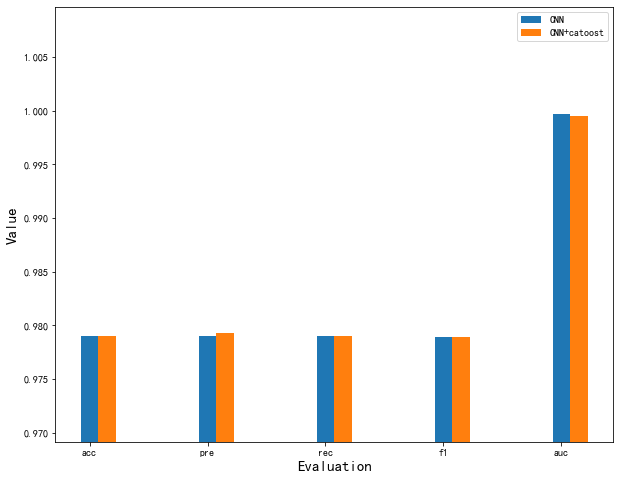

In [9]:
collect_every_model_result=pd.DataFrame(collect_every_model_result)
collect_every_model_result.index=collect_every_model_result[5]
collect_every_model_result=collect_every_model_result[range(5)]
collect_every_model_result.columns=['acc','pre','rec','f1','auc']

#将结果展示在表中    
get_result_picture(collect_every_model_result)